# **Module 3: Raster Data in Python**
## Prerequisites
### Data
In this example, we will create raster data to imitate real-world data. 
### Software
To execute the code you will need a `conda` environment for Python with the packages imported below.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from rasterio.transform import Affine
import rasterio
from shapely.geometry.polygon import Polygon
import geopandas as gpd
import rasterio.mask
from rasterstats import zonal_stats
from rasterio import features
import scipy.ndimage
import xarray as xr
from xrspatial.convolution import circle_kernel, custom_kernel
from xrspatial.focal import focal_stats
from xrspatial.zonal import stats

## Create raster data
To generate raster data in Python we use on `numpy` and `rasterio` packages. We need the following three components:
- An array of data and the xy coordinates;
- A coordinate reference system;
- A transform defining the coordinate of the upper left hand corner and the cell resolution

Generate data


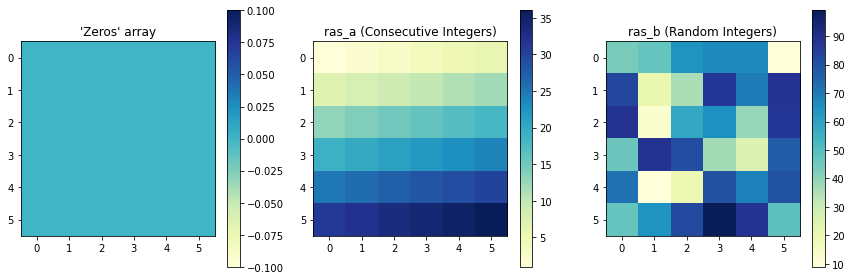

In [2]:
print ("Generate data")
ras_0 = np.zeros([6, 6])
ras_a = np.arange(1, 37).reshape(6, 6)
np.random.seed(0)
ras_b = np.random.randint(100, size=(6,6))
fig, axs = plt.subplots(1,3, figsize=(12,4))
plot0 = axs[0].imshow(ras_0, cmap="YlGnBu")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("'Zeros' array")
plot1 = axs[1].imshow(ras_a, cmap="YlGnBu")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("ras_a (Consecutive Integers)")
plot2 = axs[2].imshow(ras_b, cmap="YlGnBu")
fig.colorbar(plot2, ax=axs[2])
axs[2].set_title("ras_b (Random Integers)")
plt.tight_layout()

Genarate arrays with coordinates


Text(0.5, 1.0, 'latitude')

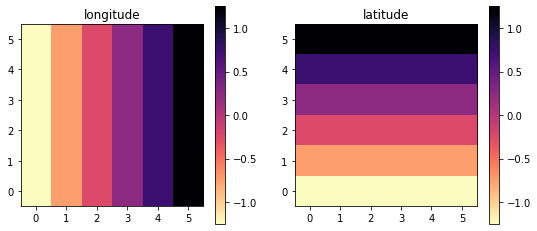

In [3]:
print ("Genarate arrays with coordinates")
x = np.linspace(-1.25, 1.25, 6)
y = np.linspace(-1.25, 1.25, 6)
X, Y = np.meshgrid(x, y)
fig, axs = plt.subplots(1,2, figsize=(9,4))
plot0 = axs[0].imshow(X, cmap="magma_r", origin="lower")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("longitude")
plot1 = axs[1].imshow(Y, cmap="magma_r",origin="lower")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("latitude")

In [4]:
print ("Define transform and save raster 'ras_a' to a file")
res=0.5
transform = Affine.translation(x[0] - res / 2, -(y[0] - res / 2)) * Affine.scale(res, -res)
with rasterio.open("./data/ras_a.tif",
                   "w",
                   driver="GTiff",
                   height=ras_a.shape[0],
                   width=ras_a.shape[1],
                   count=1,
                   dtype=np.int16,
                   crs="epsg:4326",
                   transform=transform,
                   nodata=-999
                  ) as dst:
     dst.write(ras_a, 1)

Define transform and save raster 'ras_a' to a file


## Describe raster data

Number of rows of raster b is 6
Number of colomns of raster b is 6
Number of cells of raster b is 36


(array([3., 3., 0., 4., 4., 1., 7., 4., 9., 1.]),
 array([ 9., 18., 27., 36., 45., 54., 63., 72., 81., 90., 99.]),
 <BarContainer object of 10 artists>)

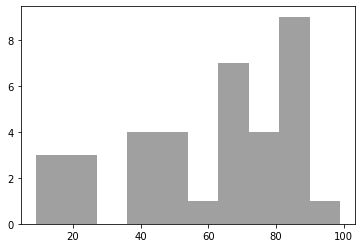

In [5]:
print ("Number of rows of raster b is {}".format(ras_b.shape[0]))
print ("Number of colomns of raster b is {}".format(ras_b.shape[1]))
print ("Number of cells of raster b is {}".format(ras_b.shape[0]*ras_b.shape[1]))
plt.hist(ras_b.flatten(), facecolor="grey", alpha=0.75)

In [6]:
print ("Raster unique values are: {}".format(np.unique(ras_b)))
print ("Get subsets of raster data")
print ("Value at position 0 col and 0 row {}".format(ras_b[0,0]))
print ("Value at position 2 col and 2 row {}".format(ras_b[2,2]))
print ("Array starting from 2 col and 2 row:")
print (ras_b[2:, 2:])

Raster unique values are: [ 9 12 20 21 25 36 37 39 44 46 47 49 58 64 65 67 69 70 72 77 79 80 81 82
 83 87 88 99]
Get subsets of raster data
Value at position 0 col and 0 row 44
Value at position 2 col and 2 row 58
Array starting from 2 col and 2 row:
[[58 65 39 87]
 [81 37 25 77]
 [20 80 69 79]
 [82 99 88 49]]


## Summarize raster data
Below we present some methods to summarize and describe array data with common statistics.

In [7]:
print ("Applying mean() function:")
print (np.mean(ras_a))
print ("Applying mean() function along axis 0:")
print (np.mean(ras_a, axis = 0)) 
print ("Applying mean() function along axis 1:")
print (np.mean(ras_a, axis = 1))
print ("Applying median() function:")
print (np.median(ras_a))
print ("Applying amax() function:")
print (np.amax(ras_a))
print ("Applying amin() function:")
print (np.amin(ras_a))
print ("Applying percentile() function:")
print (np.percentile(ras_a, 70))

Applying mean() function:
18.5
Applying mean() function along axis 0:
[16. 17. 18. 19. 20. 21.]
Applying mean() function along axis 1:
[ 3.5  9.5 15.5 21.5 27.5 33.5]
Applying median() function:
18.5
Applying amax() function:
36
Applying amin() function:
1
Applying percentile() function:
25.5


## Map algebra
Below we demonstrate examples of how to use execute a variety of map algebra expressions on one or more arrays.

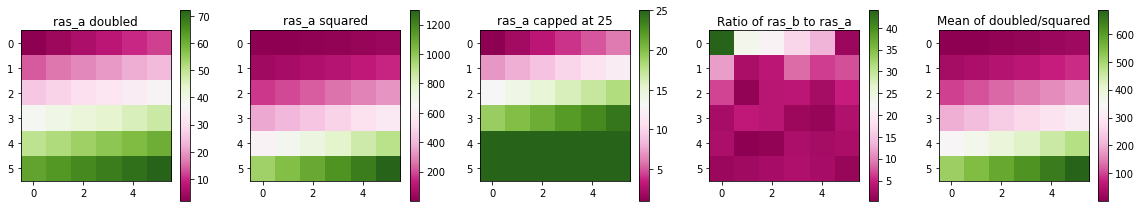

In [8]:
X2 =  ras_a*2
Sq = ras_a**2
ras_a_cap = ras_a.copy()
ras_a_cap[ras_a_cap >= 25 ] = 25
ratio = ras_b/ras_a
mean = (X2+Sq)/2

fig, axs = plt.subplots(1,5, figsize=(16,3))
plot0 = axs[0].imshow(X2, cmap="PiYG")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("ras_a doubled")
plot1 = axs[1].imshow(Sq, cmap="PiYG")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("ras_a squared")
plot2 = axs[2].imshow(ras_a_cap, cmap="PiYG")
fig.colorbar(plot2, ax=axs[2])
axs[2].set_title("ras_a capped at 25")
plot3 = axs[3].imshow(ratio, cmap="PiYG")
fig.colorbar(plot3, ax=axs[3])
axs[3].set_title("Ratio of ras_b to ras_a")
plot4 = axs[4].imshow(mean, cmap="PiYG")
fig.colorbar(plot4, ax=axs[4])
axs[4].set_title("Mean of doubled/squared")
plt.tight_layout()

## Reclassify array data
Reclassification allows to reassign one or more values in a raster dataset to new output values.

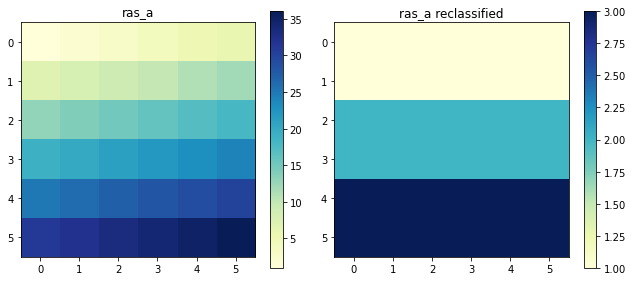

In [9]:
reclassified = ras_a.copy()
reclassified[(reclassified > 0) & (reclassified <= 12)] = 1
reclassified[(reclassified > 12) & (reclassified <= 24)] = 2
reclassified[(reclassified > 24) & (reclassified <= 37)] = 3
reclassified
fig, axs = plt.subplots(1,2, figsize=(9,4))
plot0 = axs[0].imshow(ras_a, cmap="YlGnBu")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("ras_a")
plot1 = axs[1].imshow(reclassified, cmap="YlGnBu")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("ras_a reclassified")
plt.tight_layout()

## Apply focal statistics
Focal statistics calculates a statistic for input cells with a set of overlapping windows or neighborhoods defined as `kernel`. Please note that we use `xarray` and `xarray-spatial` packages to perfrom these operations.

In [10]:
ras_b_xr =  xr.DataArray(ras_b, dims=["y", "x"], name="raster")
kernel1 = circle_kernel(1,1,1)
kernel2 = np.ones([3,3])
focal1 = focal_stats(xr.DataArray(ras_b_xr), kernel1, stats_funcs=["min"])[0]
focal2 = focal_stats(xr.DataArray(ras_b_xr), kernel2, stats_funcs=["min"])[0]
focal2

<xarray.DataArray 'focal_apply' (y: 6, x: 6)>
array([[21., 21., 21., 36.,  9.,  9.],
       [12., 12., 12., 36.,  9.,  9.],
       [12., 12., 12., 25., 25., 25.],
       [ 9.,  9.,  9., 20., 25., 25.],
       [ 9.,  9.,  9., 20., 25., 25.],
       [ 9.,  9.,  9., 20., 49., 49.]], dtype=float32)
Coordinates:
    stats    <U3 'min'
Dimensions without coordinates: y, x

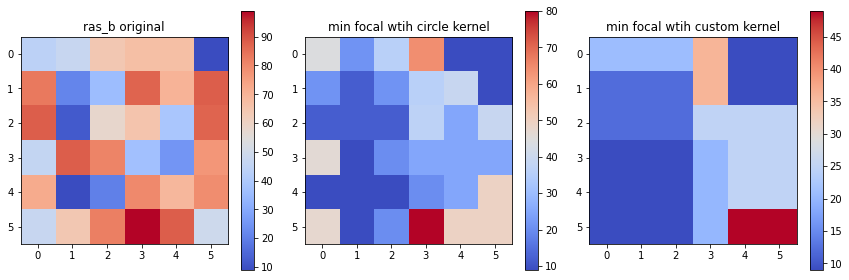

In [11]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
plot0 = axs[0].imshow(ras_b, cmap="coolwarm")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("ras_b original")
plot1 = axs[1].imshow(focal1, cmap="coolwarm") 
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("min focal wtih circle kernel")
plot2 = axs[2].imshow(focal2, cmap="coolwarm") 
fig.colorbar(plot2, ax=axs[2])
axs[2].set_title("min focal wtih custom kernel")
plt.tight_layout()

## Reshape array data to aggregate to a coarser resolution

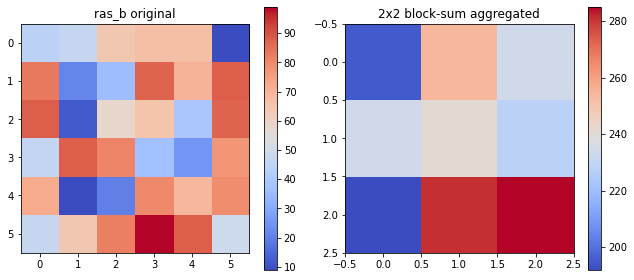

In [12]:
k=2
aggregated = np.add.reduceat(np.add.reduceat(ras_b, np.arange(0, ras_a.shape[0], k), axis=0),
                             np.arange(0, ras_a.shape[1], k), axis=1)
fig, axs = plt.subplots(1,2, figsize=(9,4))
plot0 = axs[0].imshow(ras_b, cmap="coolwarm")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("ras_b original")
plot1 = axs[1].imshow(aggregated, cmap="coolwarm")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("2x2 block-sum aggregated")
plt.tight_layout()

## Resample array data to a higher resolution

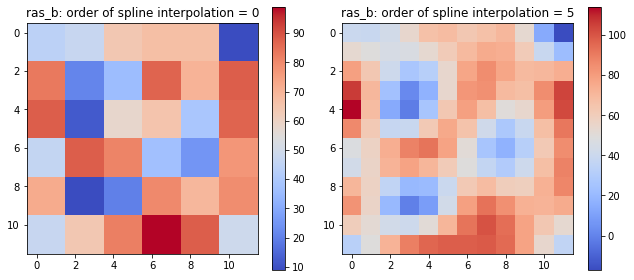

In [13]:
resampled_n = scipy.ndimage.zoom(ras_b, zoom=(2, 2), order=0, mode="nearest", grid_mode=True)
resampled_b = scipy.ndimage.zoom(ras_b, zoom=(2, 2), order=5, mode="grid-mirror", grid_mode=True)
fig, axs = plt.subplots(1,2, figsize=(9,4))
plot0 = axs[0].imshow(resampled_n, cmap="coolwarm")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("ras_b: order of spline interpolation = 0")
plot1 = axs[1].imshow(resampled_b, cmap="coolwarm")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("ras_b: order of spline interpolation = 5")
plt.tight_layout()

## Summarize array by another array
Here we show how to calculate summary statistics for each zone defined by a zones dataset, based on values array.

Create 'zones' array


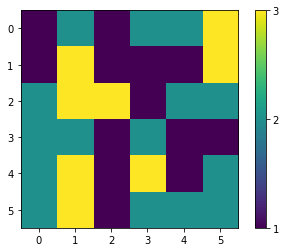

In [14]:
print ("Create 'zones' array")
np.random.seed(0)
categorical = np.random.randint(1,4, size=(6,6))
plt.imshow(categorical)
plt.colorbar(ticks=[1,2,3])

In [15]:
values = xr.DataArray(ras_a)
zones = xr.DataArray(categorical)
stats_df = stats(zones=zones, values=values)
stats_df

,zone,mean,max,min,sum,std,var,count
0,1,16.461538,33.0,1.0,214.0,9.997041,99.940828,13.0
1,2,20.733333,36.0,2.0,311.0,10.914618,119.128889,15.0
2,3,17.625000,32.0,6.0,141.0,9.109576,82.984375,8.0


## Raster-vector interactions

Create arbitrary polygon


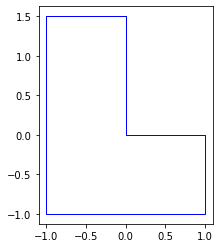

In [16]:
print ("Create arbitrary polygon")
polygon = Polygon([(0, 1.5), (0, 0), (1, 0), (1, -1), (-1, -1), (-1, 1.5)])
gdf = gpd.GeoDataFrame(index=[0], crs="epsg:4326", geometry=[polygon])
gdf.plot(facecolor="none", edgecolor="blue")
gdf.to_file("./data/pol.shp")

Extract raster by polygon


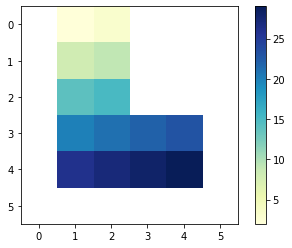

In [17]:
print ("Extract raster by polygon")
with rasterio.open("./data/ras_a.tif") as src:
    out_img, out_transform = rasterio.mask.mask(dataset=src, shapes=gdf["geometry"], 
                                                nodata=src.nodata, indexes=1, filled=False)
    ras_a_masked = out_img
plt.imshow(ras_a_masked, cmap="YlGnBu")
plt.colorbar()

In [18]:
print ("Summarize raster data by polygon shape")
with rasterio.open( "./data/ras_a.tif") as src:
    affine = src.transform
    ras_a = src.read(1)
    zs = zonal_stats("./data/pol.shp", ras_a, affine=affine, nodata=src.nodata, 
                     stats =["mean",  "count", "sum", "std", "median", "majority", "minority", "range"])
print (zs)

Summarize raster data by polygon shape
[{'mean': 17.642857142857142, 'count': 14, 'sum': 247.0, 'std': 8.885036721984912, 'median': 20.5, 'majority': 2.0, 'minority': 2.0, 'range': 27.0}]


In [19]:
print ("Rasterize polygon to a raster")
rasterized = features.rasterize(gdf["geometry"],
                                out_shape = ras_a.shape,
                                fill = 0,
                                out = None,
                                transform = affine,
                                all_touched = False,
                                default_value = zs[0]["sum"],
                                dtype = None)
print (rasterized)

Rasterize polygon to a raster
[[  0. 247. 247.   0.   0.   0.]
 [  0. 247. 247.   0.   0.   0.]
 [  0. 247. 247.   0.   0.   0.]
 [  0. 247. 247. 247. 247.   0.]
 [  0. 247. 247. 247. 247.   0.]
 [  0.   0.   0.   0.   0.   0.]]
